In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18093624276940671825
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10794928150796097949
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [4]:
import tensorflow
from tensorflow.keras import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Activation,Dense
from tensorflow.keras.layers import AveragePooling2D,concatenate,GlobalAveragePooling2D
from tensorflow.keras import Input

## Inception V3 Architecture

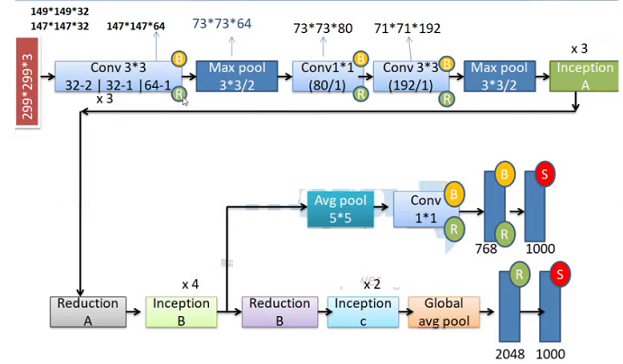

In [5]:
# Input for Inception moduel is 299*229*3
img_input = Input(shape=(299, 299, 3))

classes=3 # Three Classes
channel_axis=3

In [6]:
# Convolution Layer along with Batch Normalization and Relu activation Function
# filters : Number of Filters
# num_row,num_col : Size of the filters
# axis=3 : Channels

def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1)):
   
    x = Conv2D(filters, (num_row, num_col),strides=strides,padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)
    return x

In [7]:
def inc_block_a(x):    
    branch1x1 = conv2d_bn(x, 64, 1, 1)  # 64 filters of 1*1

    branch5x5 = conv2d_bn(x, 48, 1, 1)  #48 filters of 1*1
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
    return x

In [8]:
def reduction_block_a(x):  
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = concatenate([branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

In [9]:
# 17 x 17 x 768
def inc_block_b(x):
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1),padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=channel_axis)
    return x

In [10]:
# mixed 8: 8 x 8 x 1280
def reduction_block_b(x): 
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn( branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch7x7x3, branch_pool], axis=channel_axis)
    return x

In [11]:
def inc_block_c(x):
    branch1x1 = conv2d_bn(x, 320, 1, 1)

    branch3x3 = conv2d_bn(x, 384, 1, 1)
    branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
    branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
    branch3x3 = concatenate([branch3x3_1, branch3x3_2],axis=channel_axis)

    branch3x3dbl = conv2d_bn(x, 448, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
    branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
    branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
    branch3x3dbl = concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate( [branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=channel_axis)
    return x

In [12]:
# Building a model layer by layer

In [30]:
# input image size: 299 x 299 x 3
x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid') # 149 x 149 x 32
x = conv2d_bn(x, 32, 3, 3, padding='valid')  # 147 x 147 x 32
x = conv2d_bn(x, 64, 3, 3) # 147 x 147 x 64
x = MaxPooling2D((3, 3), strides=(2, 2))(x)   # 73  x 73 x 64

x = conv2d_bn(x, 80, 1, 1, padding='valid') # 73 x 73 x 80
x = conv2d_bn(x, 192, 3, 3, padding='valid')  # 71 x 71 x 192
x = MaxPooling2D((3, 3), strides=(2, 2))(x)  # 35 x 35 x 192

# Inception will start here : 
# Inception A Block : 3
x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256
x=inc_block_a(x) #35, 35, 256

# Reduction Block A
x=reduction_block_a(x) #17, 17, 736

# Inception B Block : 4
x = inc_block_b(x)
x = inc_block_b(x)
x = inc_block_b(x)
x = inc_block_b(x)

x=reduction_block_b(x) #shape=(None, 8, 8, 1280)

x=inc_block_c(x) # shape=(None, 8, 8, 2048) 
x=inc_block_c(x) # shape=(None, 8, 8, 2048) 

x = GlobalAveragePooling2D(name='avg_pool')(x) # shape=(None, 2048)

x = Dense(classes, activation='softmax', name='predictions')(x) #shape=(None, 3) 

# Create model.
inputs = img_input
model =  Model(inputs, x, name='inception_v3')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
% cd /content/drive/MyDrive/ComputerVision/dataset/ImgClassification

/content/drive/MyDrive/ComputerVision/dataset/ImgClassification


In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset')

room_types = os.listdir('/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset')
print (room_types)  #what kinds of rooms are in this dataset

print("Types of rooms found: ", len(dataset_path))

['bed_room', 'dining_room', 'living_room']
Types of rooms found:  3


In [18]:
rooms = []

for item in room_types:
 # Get all the file names
 all_rooms = os.listdir('rooms_dataset' + '/' +item)
 #print(all_shoes)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('rooms_dataset' + '/' +item) + '/' + room))
    print(rooms)

[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1846251__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1846251__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1303451__340.jpg')]
[('bed_room', 'rooms_dataset/bed_room/architecture-modern-house-beautiful-interiors-260nw-278631791.jpg'), ('bed_room', 'rooms_dataset/bed_room/bed-1048194__340.jpg'), ('bed_room', 'rooms_dataset/bed_room/b

In [19]:
# Build a dataframe        
rooms_df = pd.DataFrame(data=rooms, columns=['room type', 'image'])
print(rooms_df.head())

  room type                                              image
0  bed_room  rooms_dataset/bed_room/architecture-modern-hou...
1  bed_room        rooms_dataset/bed_room/bed-1048194__340.jpg
2  bed_room        rooms_dataset/bed_room/bed-1846251__340.jpg
3  bed_room        rooms_dataset/bed_room/bed-1303451__340.jpg
4  bed_room    rooms_dataset/bed_room/bed-4540208__340 (1).jpg


In [20]:
# Let's check how many samples for each category are present
print("Total number of rooms in the dataset: ", len(rooms_df))

room_count = rooms_df['room type'].value_counts()

print("rooms in each category: ")
print(room_count)

Total number of rooms in the dataset:  37
rooms in each category: 
living_room    14
bed_room       12
dining_room    11
Name: room type, dtype: int64


In [21]:
import cv2
path = '/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset/'

im_size = 299

images = []
labels = []

for i in room_types:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [22]:
images[0].shape

(299, 299, 3)

In [23]:
images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(37, 299, 299, 3)

In [24]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
y=rooms_df['room type'].values
#print(y[:5])

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [25]:
y=y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder

# binary encode
onehot_encoder = OneHotEncoder(categories='auto',sparse=False)
Y = onehot_encoder.fit_transform(y)

In [26]:
Y.shape

(37, 3)

In [27]:
Y[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [28]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(35, 299, 299, 3)
(35, 3)
(2, 299, 299, 3)
(2, 3)


In [31]:
model.fit(train_x, train_y, epochs = 3, batch_size = 32)

Epoch 1/3
2/2 [==============================] - 50s 3s/step - loss: 1.3151 - accuracy: 0.3429
Epoch 2/3
2/2 [==============================] - 1s 186ms/step - loss: 2.3893 - accuracy: 0.4571
Epoch 3/3
2/2 [==============================] - 1s 185ms/step - loss: 1.2918 - accuracy: 0.5714


In [32]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
#print ("Test Accuracy = " + str(preds[1]))

1/1 [==============================] - 3s 3s/step - loss: 1.3417 - accuracy: 0.0000e+00
Loss = 1.341666579246521


Input image shape: (1, 299, 299, 3)


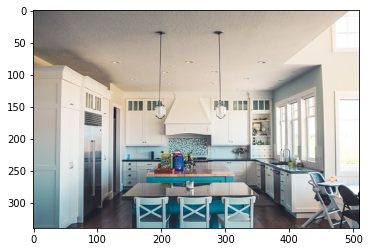

In [37]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow

img_path = '/content/drive/MyDrive/ComputerVision/dataset/ImgClassification/rooms_dataset/dining_room/kitchen-2565105__340.jpg'

img = image.load_img(img_path, target_size=(299, 299))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [38]:
print(model.predict(x))

[[0. 0. 1.]]


In [39]:
import numpy as np
np.argmax(model.predict(x))

2